In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras import losses
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.models import Sequential
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
data= pd.read_csv("/content/drive/MyDrive/kaggle_data/jena_climate.csv/jena_climate_2009_2016.csv")

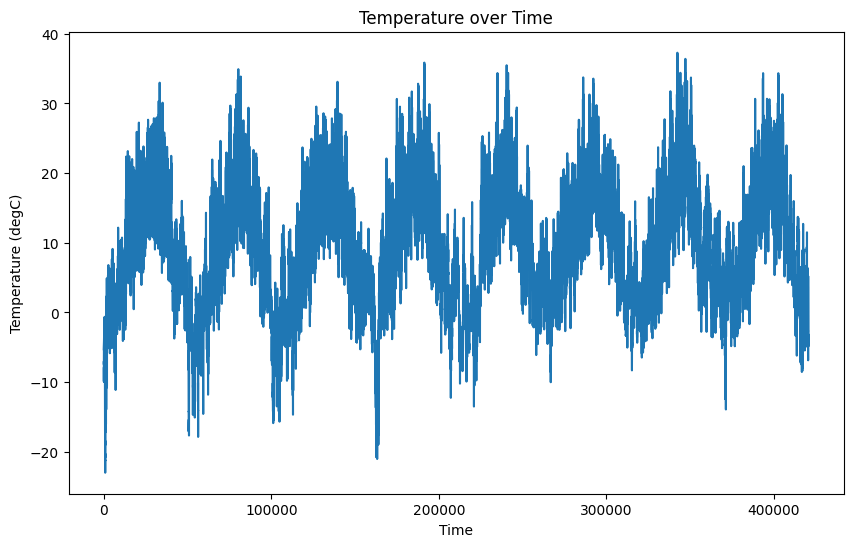

In [ ]:
# Time series plots
plt.figure(figsize=(10,6))
plt.plot(data['T (degC)'])
plt.title('Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.show()

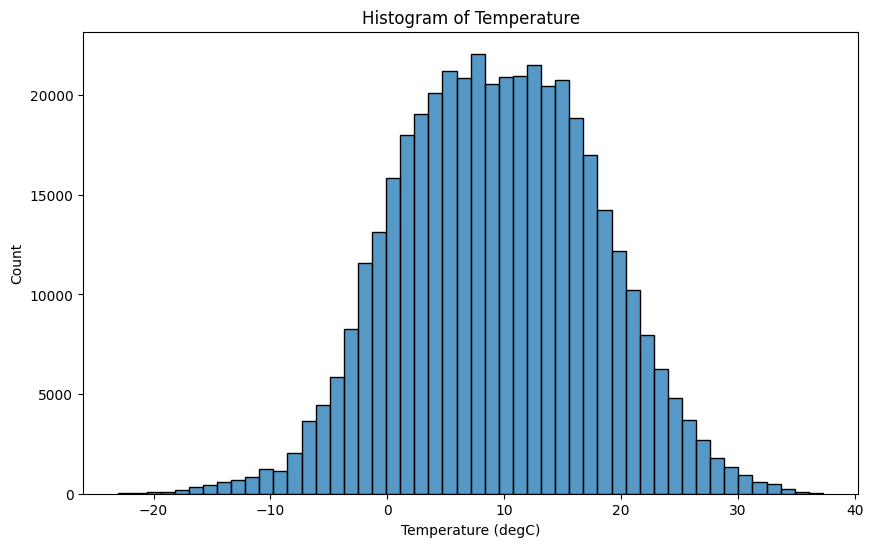

In [ ]:
# Histogram
plt.figure(figsize=(10,6))
sns.histplot(data['T (degC)'], bins=50)
plt.title('Histogram of Temperature')
plt.xlabel('Temperature (degC)')
plt.show()

<ipython-input-5-c59cce8fd5aa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


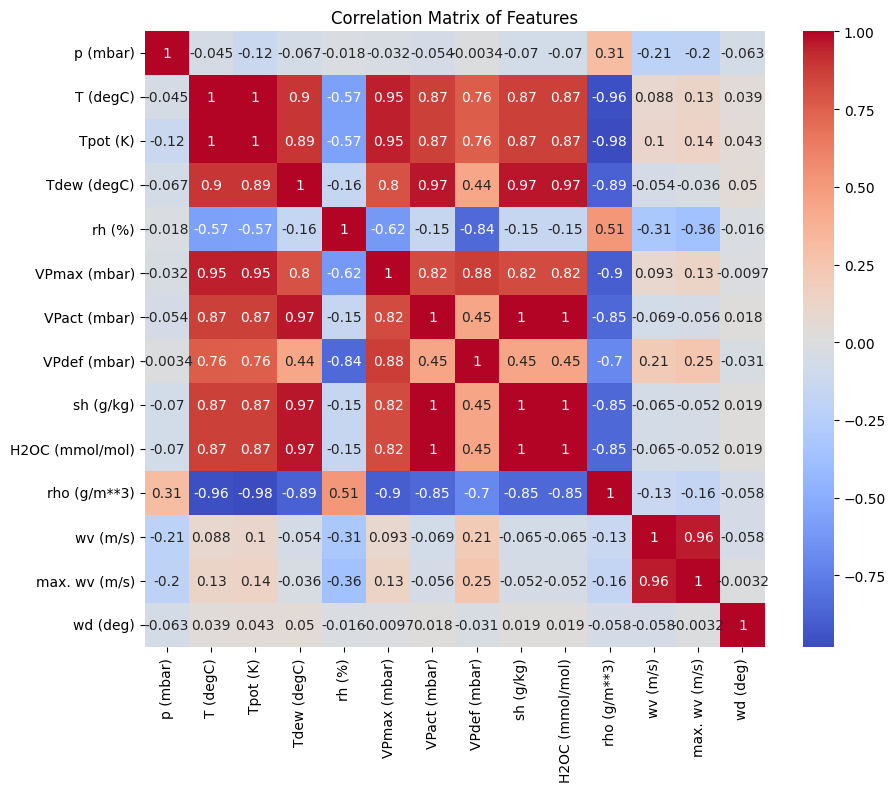

In [ ]:
# Correlation Matrices
correlation_matrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
correlation_matrix = data.corr()

# We only take correlations higher than a certain threshold. For example, 0.8.
high_corr = correlation_matrix[correlation_matrix > 0.8]

# We remove the NaN values and turn the matrix into a list.
high_corr_pairs = high_corr.unstack().sort_values(ascending=False).dropna()

# We remove correlations between the same features (will always be 1).
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

print(high_corr_pairs)

<ipython-input-3-8a1462cbff52>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


sh (g/kg)        H2OC (mmol/mol)    0.999997
H2OC (mmol/mol)  sh (g/kg)          0.999997
VPact (mbar)     H2OC (mmol/mol)    0.999856
H2OC (mmol/mol)  VPact (mbar)       0.999856
sh (g/kg)        VPact (mbar)       0.999851
VPact (mbar)     sh (g/kg)          0.999851
T (degC)         Tpot (K)           0.996826
Tpot (K)         T (degC)           0.996826
Tdew (degC)      VPact (mbar)       0.968334
VPact (mbar)     Tdew (degC)        0.968334
H2OC (mmol/mol)  Tdew (degC)        0.968034
Tdew (degC)      H2OC (mmol/mol)    0.968034
sh (g/kg)        Tdew (degC)        0.967589
Tdew (degC)      sh (g/kg)          0.967589
max. wv (m/s)    wv (m/s)           0.957343
wv (m/s)         max. wv (m/s)      0.957343
T (degC)         VPmax (mbar)       0.951109
VPmax (mbar)     T (degC)           0.951109
                 Tpot (K)           0.947289
Tpot (K)         VPmax (mbar)       0.947289
T (degC)         Tdew (degC)        0.895707
Tdew (degC)      T (degC)           0.895707
Tpot (K)  

In [ ]:
# Finding highly correlated features
high_corr_features = set()
corr_matrix = data.corr().abs()

# Take the upper triangular matrix (because the correlation matrix is symmetric)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# For each column, find features with correlation greater than 0.95
for column in upper.columns:
    if any(upper[column] > 0.95):
        high_corr_features.add(column)

print("Features to be removed: ", high_corr_features)
df = data.drop(high_corr_features, axis=1)

<ipython-input-4-616f89463e95>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr().abs()


Features to be removed:  {'sh (g/kg)', 'Tpot (K)', 'VPmax (mbar)', 'rho (g/m**3)', 'max. wv (m/s)', 'H2OC (mmol/mol)', 'VPact (mbar)'}


<ipython-input-4-616f89463e95>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [ ]:
data = data.drop(['Date Time'], axis=1)

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Set hyperparameters
n_features = scaled_data.shape[1]
n_steps = 60
n_neurons = 50
dropout_rate = 0.2
n_epochs = 50
batch_size = 32

In [ ]:
# Create 60 time-step data structures and output 1
# For example, to predict the column 'T (degC)'
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i])
    y.append(scaled_data[i, 2]) # 'T (degC)' property is located at index 2

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))

In [ ]:
# Separate data into train, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=0)

In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], n_features)))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=n_neurons, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=n_neurons))
model.add(Dropout(dropout_rate))
model.add(Dense(units = 1))


In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
from keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss <= 0.0005:
            print("\nValidation loss is below 0.0005, stopping training")
            self.model.stop_training = True

custom_callback = CustomCallback()

In [ ]:
history = model.fit(X_train, y_train, epochs=100,batch_size= 32, validation_data=(X_val, y_val), callbacks=[custom_callback])

Epoch 1/100
7882/7883 [============================>.] - ETA: 0s - loss: 9.2035e-04 - mean_absolute_error: 0.0196
Validation loss is below 0.0005, stopping training
7883/7883 [==============================] - 94s 11ms/step - loss: 9.2032e-04 - mean_absolute_error: 0.0196 - val_loss: 1.0410e-04 - val_mean_absolute_error: 0.0078


In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Compare actual and predicted values
rmse = metrics.RootMeanSquaredError()
mse = metrics.MeanSquaredError()
mae = metrics.MeanAbsoluteError()

print("Root Mean Squared Error:", rmse(y_test, y_pred).numpy())
print("Mean Squared Error:", mse(y_test, y_pred).numpy())
print("Mean Absolute Error:", mae(y_test, y_pred).numpy())

2628/2628 [==============================] - 11s 4ms/step
Root Mean Squared Error: 0.0102083525
Mean Squared Error: 0.00010421046
Mean Absolute Error: 0.0078059346


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Set Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []  # Let's create a list to store RMSE scores

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Model creation and training
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=['mean_absolute_error'])

    history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=( X_val, y_val))

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Take the average of RMSE scores
average_rmse = np.mean(rmse_scores)

print('5-Fold Time Series Cross Validation Result Average RMSE:', average_rmse)


Epoch 1/10
2190/2190 [==============================] - 171s 75ms/step - loss: 0.0015 - mean_absolute_error: 0.0112 - val_loss: 4.3355e-05 - val_mean_absolute_error: 0.0047
Epoch 2/10
2190/2190 [==============================] - 164s 75ms/step - loss: 3.7611e-05 - mean_absolute_error: 0.0045 - val_loss: 3.1120e-05 - val_mean_absolute_error: 0.0041
Epoch 3/10
2190/2190 [==============================] - 163s 74ms/step - loss: 2.9264e-05 - mean_absolute_error: 0.0040 - val_loss: 3.4634e-05 - val_mean_absolute_error: 0.0048
Epoch 4/10
2190/2190 [==============================] - 164s 75ms/step - loss: 2.4941e-05 - mean_absolute_error: 0.0037 - val_loss: 2.1599e-05 - val_mean_absolute_error: 0.0035
Epoch 5/10
2190/2190 [==============================] - 161s 74ms/step - loss: 2.2119e-05 - mean_absolute_error: 0.0034 - val_loss: 3.6905e-05 - val_mean_absolute_error: 0.0050
Epoch 6/10
2190/2190 [==============================] - 161s 74ms/step - loss: 1.9032e-05 - mean_absolute_error: 0.0032

Epoch 1/10
4380/4380 [==============================] - 302s 69ms/step - loss: 4.8757e-04 - mean_absolute_error: 0.0079 - val_loss: 3.1155e-05 - val_mean_absolute_error: 0.0043
Epoch 2/10
4380/4380 [==============================] - 299s 68ms/step - loss: 2.8731e-05 - mean_absolute_error: 0.0040 - val_loss: 1.6229e-05 - val_mean_absolute_error: 0.0027
Epoch 3/10
4380/4380 [==============================] - 298s 68ms/step - loss: 2.1345e-05 - mean_absolute_error: 0.0034 - val_loss: 1.3870e-05 - val_mean_absolute_error: 0.0024
Epoch 4/10
4380/4380 [==============================] - 301s 69ms/step - loss: 1.8761e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4227e-05 - val_mean_absolute_error: 0.0026
Epoch 5/10
4380/4380 [==============================] - 298s 68ms/step - loss: 1.7072e-05 - mean_absolute_error: 0.0030 - val_loss: 2.2124e-05 - val_mean_absolute_error: 0.0036
Epoch 6/10
4380/4380 [==============================] - 297s 68ms/step - loss: 1.6322e-05 - mean_absolute_error: 0.

Epoch 1/10
6569/6569 [==============================] - 439s 67ms/step - loss: 2.8834e-04 - mean_absolute_error: 0.0064 - val_loss: 3.1174e-05 - val_mean_absolute_error: 0.0045
Epoch 2/10
6569/6569 [==============================] - 437s 67ms/step - loss: 2.0553e-05 - mean_absolute_error: 0.0033 - val_loss: 1.4364e-05 - val_mean_absolute_error: 0.0027
Epoch 3/10
6569/6569 [==============================] - 441s 67ms/step - loss: 1.7241e-05 - mean_absolute_error: 0.0030 - val_loss: 1.6918e-05 - val_mean_absolute_error: 0.0031
Epoch 4/10
6569/6569 [==============================] - 438s 67ms/step - loss: 1.5689e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2379e-05 - val_mean_absolute_error: 0.0023
Epoch 5/10
6569/6569 [==============================] - 437s 66ms/step - loss: 1.4865e-05 - mean_absolute_error: 0.0027 - val_loss: 1.4091e-05 - val_mean_absolute_error: 0.0026
Epoch 6/10
6569/6569 [==============================] - 437s 67ms/step - loss: 1.4396e-05 - mean_absolute_error: 0.

Epoch 1/10
8759/8759 [==============================] - 577s 66ms/step - loss: 8.4624e-05 - mean_absolute_error: 0.0045 - val_loss: 1.6205e-05 - val_mean_absolute_error: 0.0030
Epoch 2/10
8759/8759 [==============================] - 575s 66ms/step - loss: 1.6253e-05 - mean_absolute_error: 0.0029 - val_loss: 2.8198e-05 - val_mean_absolute_error: 0.0045
Epoch 3/10
8759/8759 [==============================] - 572s 65ms/step - loss: 1.4820e-05 - mean_absolute_error: 0.0027 - val_loss: 1.2082e-05 - val_mean_absolute_error: 0.0022
Epoch 4/10
8759/8759 [==============================] - 578s 66ms/step - loss: 1.3783e-05 - mean_absolute_error: 0.0026 - val_loss: 1.5488e-05 - val_mean_absolute_error: 0.0029
Epoch 5/10
8759/8759 [==============================] - 573s 65ms/step - loss: 1.3382e-05 - mean_absolute_error: 0.0025 - val_loss: 1.5742e-05 - val_mean_absolute_error: 0.0030
Epoch 6/10
8759/8759 [==============================] - 573s 65ms/step - loss: 1.3026e-05 - mean_absolute_error: 0.